# CATE estimation with unconfounded data
Here, we explore the effectiveness of different scoring metrics in capturing the error between the estimated and true causal effects in small synthetic datasets.  
The data generating process simulates a randomised control trial in which covariates and treatment both affect the outcome, but treatment assignment is fully random.  

## Background
Often, different units are suceptible to a treatment to different degrees. Our goal is to use our toolbox to estimate these heterogenous treatment effects and assess how well the toolbox performs
In other words, how well does a score reflect the mismatch between the estimated and true causal effect?  
We divide our approach in different parts. First, we'll generate some synthetic data for which we know the relationship between variables, as well as the treatment effect. 
We'll consider two scenarios, with and without confounding variables. Next, we'll use CausalTune for hyperparameter tuning and model selection of a zoo of causal estimators. We'll do this for different scoring methods.
Lastly, we'll plot the returned scores against the misestimation error between predicted and true treatment effect. 
Below, we import the relevant modules and define a few helper functions (TODO outsource the latter to causaltune, once approved)

In [6]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy 

import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..
try:
    import graphviz
except ModuleNotFoundError as e:
    import pip
    pip.main(["install","graphviz"])
    import graphviz

from typing import Union

root_path = root_path = os.path.realpath('../../../..')
print(root_path)
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "causaltune"))

from sklearn.model_selection import train_test_split
from causaltune import CausalTune
from causaltune.data_utils import CausalityDataset
from causaltune.datasets import generate_synthetic_data


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/andrin/Documents/GitHub


Frobenius Subset that works (30s component tb):
estimator_list = [".LinearDML","SLearner","XLearner","TLearner","Ortho"]

In [7]:
# set a few params
metrics = ["frobenius_norm",
            #"policy_risk",
            #"norm_erupt", 
            #"qini",
             #"prob_erupt",
            # "codec",
            # "psw_energy_distance",
            # "energy_distance"
    ]

estimator_list = [
             #"Dummy",
             "SparseLinearDML",
             "ForestDRLearner",
             "TransformedOutcome",
             "CausalForestDML",
             ".LinearDML",
             "DomainAdaptationLearner", 
             #"SLearner", 
             "XLearner",
             #"TLearner", 
             #"Ortho"     
    ] 

n_samples = 1000
test_size = 0.33 # equal train,val,test
#time_budget = 21600 
components_time_budget = 20
#estimator_list = "metalearners"
n_runs = 1
out_dir = ""
filename_out = "synthetic_rct_cate_prob_erupt_retest" 


We will begin with a simple synthetic dataset, in which the outcome is influenced by the treatment and a set of covariates, which are independent of the treatment:

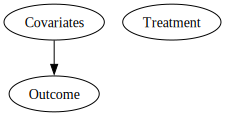

In [8]:
dot = graphviz.Digraph("causal-graph",comment="A simple causal graph",filename="rct_cate_graph.gv")
dot.node("X",label="Covariates")
dot.node("T",label="Treatment")
dot.node("Y",label="Outcome")
dot.edge("X","Y")
dot.edge_attr.update(arrowsize="1")
dot

### 1.1 Dataset generation

Let $X^{Nxd}$ be the matrix of $N$ observations and $d$ covariates, $T^{nx1}$ the vector of treatment assignments and $Y^{nx1}$ the vector of outcomes. 
We make the following assumptions:  
- binary treatments
- fully random propensity to treat (unconfoundedness)
- five continuous, normally distributed covariates
- no interaction between treatment effects and covariates 
- independence of the covariates, i.e. $\Sigma = \sigma^2I$
- no additive noise in the outcomes, i.e. $\epsilon=0$

  
Then, the data is generated according to the following equations:
\begin{align*}
& X_i \sim \mathcal{N}(0,\Sigma) \\\\
& T_i \sim Bernoulli(0.5) \\\\
& Y_i = \tau(X_i) T_i + \mu_0(X_i) + \epsilon
\end{align*}
where $i$ indexes individual units, $\tau$ describes the following true treatment effect, which depends linearly on all covariates:
\begin{equation*}
\tau(X_i) = X_ib^T + e
\end{equation*}
where $b$ is a 1xd vector of $b_i \sim U(0.4,0.7)$ weights for each covariate and $e \sim \mathcal{N}(0,0.05)$ gaussian noise.  
... and  $\mu_0(x)$ describes the following transformation of the covariates (to keep things interesting):
\begin{equation*}
\mu_0(X_i) = X_{i,1} \otimes X_{i,2} + X_{i,3} + X_{i,4} \otimes X_{i,5} 
\end{equation*}




### 1.2 Preprocessing
Now we apply CausalTune's built-in preprocessing pipeline and construct train/val/test sets

In [9]:
cd = generate_synthetic_data(n_samples=n_samples, confounding=False,noisy_outcomes=True)
cd.preprocess_dataset()
# drop true effect:
features_X = [f for f in cd.common_causes if f != "true_effect"]
print(f"Common causes: {cd.common_causes}")
print(f"Effect modifieres: {cd.effect_modifiers}")
cd.data.head(10)



Common causes: ['random']
Effect modifieres: ['X1', 'X2', 'X3', 'X4', 'X5']


,treatment,outcome,true_effect,base_outcome,random,X1,X2,X3,X4,X5,propensity
0,0,-0.068580,0.022171,-0.068580,1.0,-0.020121,-0.049797,-0.055851,-0.029152,-0.017807,0.5
1,1,0.250522,0.232397,0.018126,1.0,0.097856,0.000462,-0.007896,0.076985,0.089652,0.5
2,0,-0.053227,0.054965,-0.053227,1.0,0.005438,-0.026976,-0.018821,-0.048607,0.042930,0.5
3,0,-0.092205,0.039711,-0.092205,0.0,-0.042089,0.003606,-0.100951,0.045731,-0.025023,0.5
4,1,-0.120265,-0.031829,-0.088436,0.0,-0.014300,-0.039475,-0.078270,0.006578,-0.103077,0.5
5,0,-0.005789,0.085660,-0.005789,0.0,0.023537,0.023662,-0.032925,-0.008613,-0.058295,0.5
6,1,0.069811,0.052611,0.017200,1.0,-0.048889,0.008274,0.035865,-0.042814,-0.043814,0.5
7,1,0.292797,0.184769,0.108027,0.0,0.075864,-0.022602,0.072756,0.030254,0.021872,0.5
8,1,0.000515,0.057650,-0.057135,0.0,-0.085906,0.016948,-0.023088,-0.009516,-0.011922,0.5
9,1,-0.010255,0.053041,-0.063296,1.0,-0.005608,0.010245,-0.000690,-0.019643,-0.069139,0.5


### 1.3 Model fitting
Now we're ready to find the best fitting model, given a user-specified metric. As we'd like to compare different metrics, we'll be doing this in a for-loop

In [11]:
import copy
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import time


# Assuming CausalTune and other necessary imports are already in place

for i_run in range(1, n_runs + 1):
    
    cd_i = copy.deepcopy(cd)
    train_df, test_df = train_test_split(cd_i.data, test_size=test_size)
    test_df = test_df.reset_index(drop=True)
    cd_i.data = train_df
    
    for metric in metrics:
        print("___________________________________________________________________________")
        print("EVALUATING: ", metric)

        start_time = time.time()

        ct = CausalTune(
            propensity_model = "auto",
            metric=metric,
            metrics_to_report = [metric],
            verbose=1,
            components_verbose=1,
            components_time_budget=components_time_budget,
            estimator_list=estimator_list,
            store_all_estimators=True,
        )

        ct.fit(
            data=cd_i,
            treatment="treatment",
            outcome="outcome",
        )

        # compute relevant scores (skip newdummy)
        datasets = {"train": ct.train_df, "validation": ct.test_df, "test": test_df}
        # get scores on train, val, test for each trial, 
        # sort trials by validation set performance
        # assign trials to estimators
        estimator_scores = {est: [] for est in ct.scores.keys() if "NewDummy" not in est}
        
        #print("MMMMMMMMMMMMMMMMMMMMMMMMMM")
        #print(ct.results.trials)
        for trial in ct.results.trials:
            # estimator name:
            estimator_name = trial.last_result["estimator_name"]
            # print("UUUUUUUUUUUUUUU")
            # print("ESTIMATOR NAME: ", estimator_name)
            # try:
            #     print("trial.last_result[estimator]: ", trial.last_result["estimator"])
            # except AttributeError:
            #     print("object might not have attribute '_target_units'")
            
            #return np.inf
            #print("trial.last_result[estimator]: ", trial.last_result["estimator"])
            # print("end of last trial data")
            if trial.last_result["estimator"]:
                estimator = trial.last_result["estimator"]
                scores = {}
                for ds_name, df in datasets.items():
                    #print("ds_name: ", ds_name)
                    scores[ds_name] = {}
                    # make scores
                    est_scores = ct.scorer.make_scores(
                        estimator,
                        df,
                        metrics_to_report=ct.metrics_to_report,
                    )
                    #print("EST SCORES: ", est_scores)
                    # add cate:
                    scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
                    # add ground truth for convenience
                    scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
                    # print("METRIC: ", metric)
                    # print("EST SCORES: ", est_scores)
                    # print("EST SCORES [METRIC]: ", est_scores[metric])
                    scores[ds_name][metric] = est_scores[metric]
                estimator_scores[estimator_name].append(scores)

        # sort trials by validation performance
        #print("ESTIMATOR SCORES: ", estimator_scores)
        for k in estimator_scores.keys():
            estimator_scores[k] = sorted(
                estimator_scores[k],
                key=lambda x: x["validation"][metric],
                reverse=False if metric in ["energy_distance", "psw_energy_distance", "frobenius_norm", "codec"] else True,
            )
        results = {
            "best_estimator": ct.best_estimator,
            "best_config": ct.best_config,
            "best_score": ct.best_score,
            "optimised_metric": metric,
            "scores_per_estimator": estimator_scores,
        }

        with open(f"{out_dir}{filename_out}_{metric}_run_{i_run}.pkl", "wb") as f:
            pickle.dump(results, f)

        end_time = time.time()
        # Calculate the elapsed time
        elapsed_time = end_time - start_time

        print(f"COMPUTE TIME: {elapsed_time} seconds")
        print("DONE WITH METRIC...")

        #print("RESULTS: ",results)
        print("___________________________________________________________________________")

print("---[DONE]---")

___________________________________________________________________________
EVALUATING:  frobenius_norm
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully


[flaml.tune.tune: 07-26 00:40:12] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-26 00:40:12] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}


Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': True, 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': True, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 0.0001, 'max_iter': 10000, 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_lea

[flaml.tune.tune: 07-26 00:41:53] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}


COMPUTING FROBENIUS
WEIGHTS:  [1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526

KeyboardInterrupt: 

COMPUTING FROBENIUS
WEIGHTS:  [1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316 1.0526316
 1.0526316 1.0526316 1.0526316 1.0526316 1.0526

### 1.4 Evaluation
How well did the different metrics quantify the mismatch between estimated and true treatment effects?

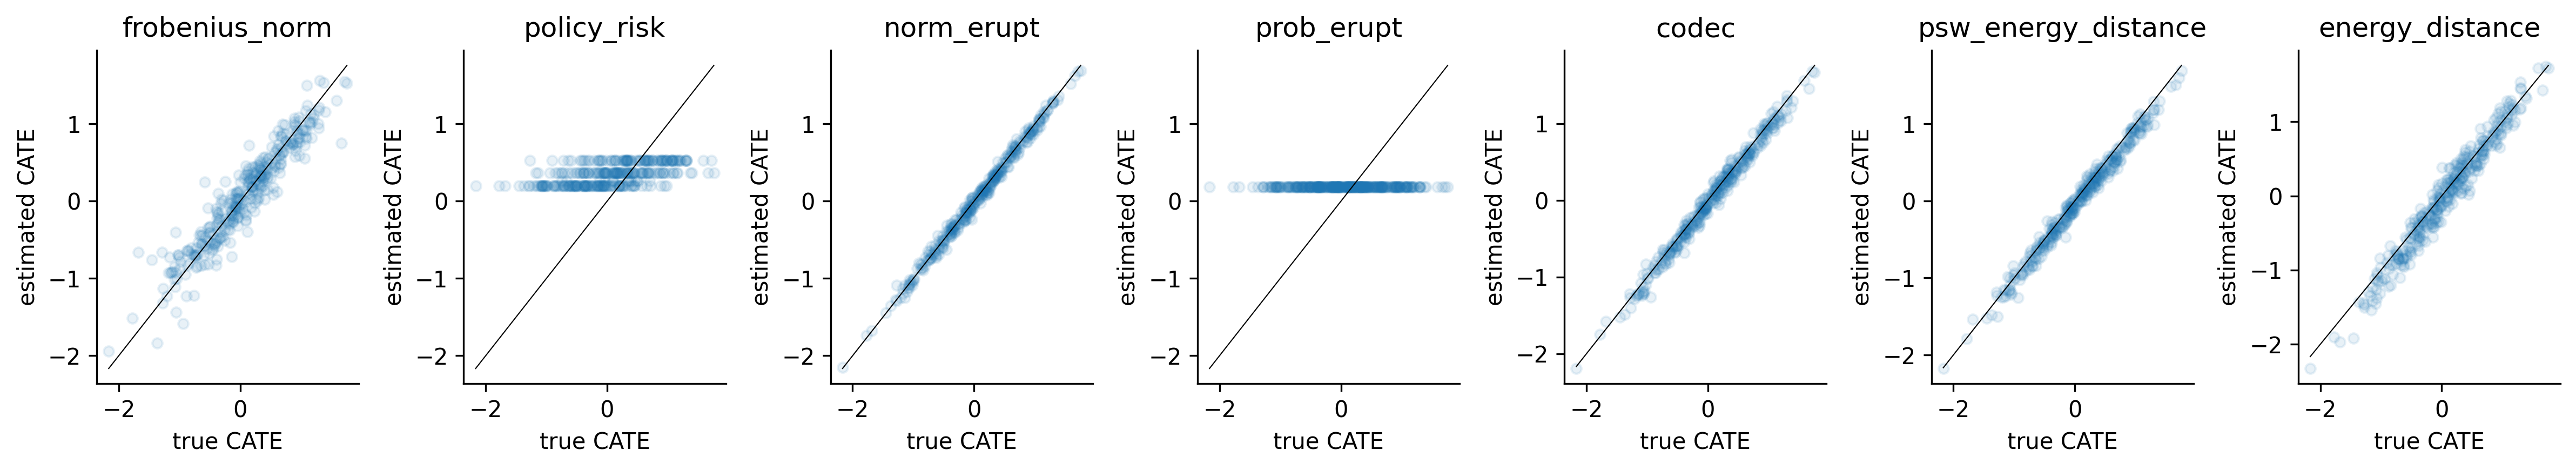

In [13]:
%matplotlib inline
f, axs = plt.subplots(1,len(metrics),figsize=(16,3),dpi=300)

# plot true against estimated for best estimator:
for ax, metric in zip(axs, metrics):

    with open(f"{out_dir}{filename_out}_{metric}_run_1.pkl","rb") as f:
        results = pickle.load(f)
    #print(results["scores_per_estimator"])
    CATE_gt = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_groundtruth"]
    CATE_est = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_estimate"]
    

    ax.scatter(CATE_gt,CATE_est,s=20,alpha=0.1)
    
    ax.plot([min(CATE_gt),max(CATE_gt)],[min(CATE_gt),max(CATE_gt)],"k-",linewidth=0.5)
    ax.set_xlabel("true CATE")
    ax.set_ylabel("estimated CATE")
    ax.set_title(f"{results['optimised_metric']}")
    #ax.set_xlim([-0.2,0.2])
    #ax.set_ylim([-0.2,0.2])
    #ax.set_xticks(np.arange(-0.2,0.21,0.2))
    #ax.set_yticks(np.arange(-0.2,0.21,0.2))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout() 
plt.savefig(f"paper_{filename_out}_mse.pdf",format="pdf")

now plot the score against the mse between estimated and true cate for each of the models in the scores dict

backdoor.econml.dml.LinearDML: 3 intermediate runs 
backdoor.econml.dml.LinearDML: 3 intermediate runs 
backdoor.econml.dml.LinearDML: 2 intermediate runs 
backdoor.econml.dml.LinearDML: 3 intermediate runs 
backdoor.econml.dml.LinearDML: 2 intermediate runs 
backdoor.econml.dml.LinearDML: 2 intermediate runs 
backdoor.econml.dml.LinearDML: 2 intermediate runs 


<Figure size 4200x1200 with 0 Axes>

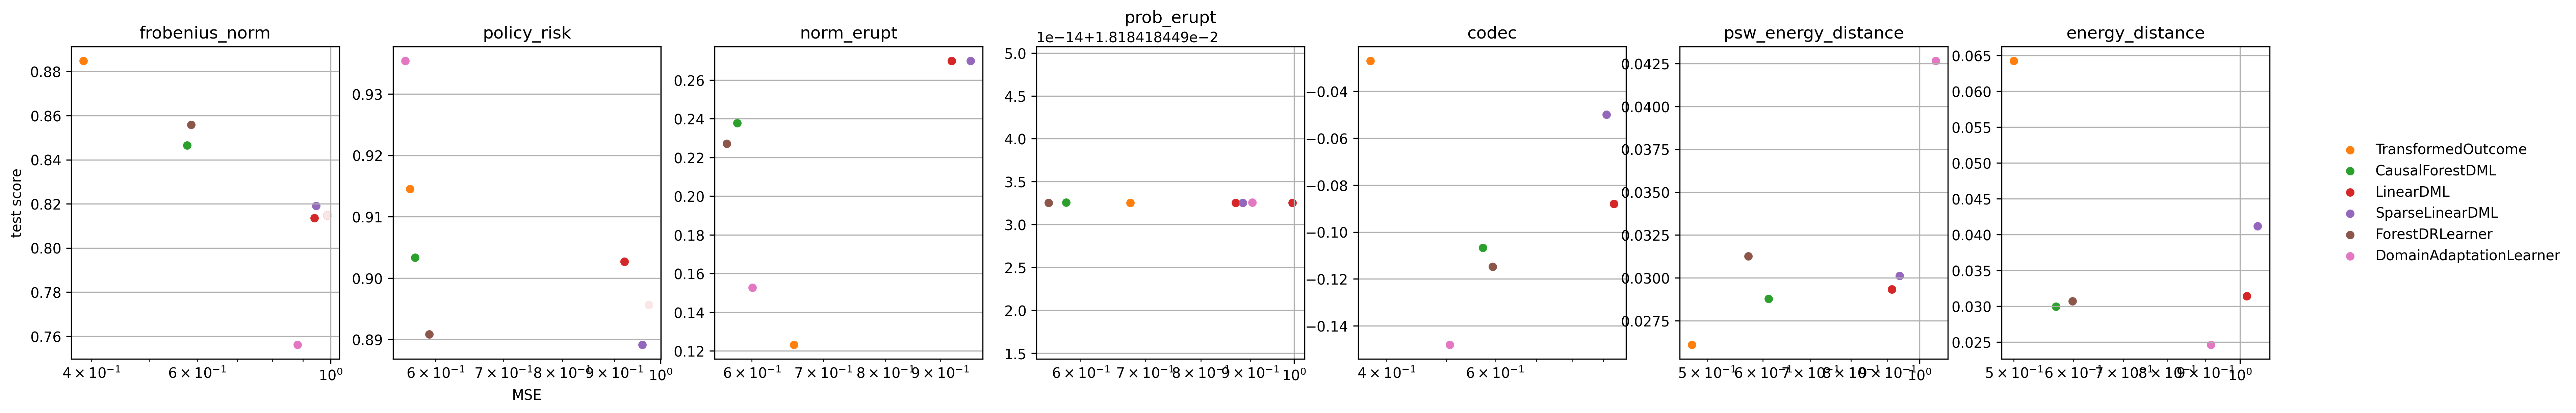

In [25]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])

plt.figure(figsize=(14,4),dpi=300)
f, axs = plt.subplots(1,len(metrics),figsize=(len(metrics)*4,4),dpi=300)

est_labels = [[] for _ in range(len(metrics))]

sc = [[] for _ in range(len(metrics))]

for i, metric in enumerate(metrics):

    plt.subplot(1, len(metrics), i+1)
    with open(f"{out_dir}{filename_out}_{metric}_run_1.pkl","rb") as f:
        results = pickle.load(f)
    
    for (est_name, scr), col in zip(results["scores_per_estimator"].items(),colors): 
        if "Dummy" not in est_name:
            if len(scr):
                # also plot intermediate runs:
                if len(scr) > 1:
                    print(f"{est_name}: {len(scr)} intermediate runs ")
                    lightness = np.linspace(1,2.8,len(scr))
                    
                    col_rgb = matplotlib.colors.ColorConverter.to_rgb(col)
                    for i_run in range(1,len(scr)):
                        CATE_gt = scr[i_run]["test"]["CATE_groundtruth"]
                        CATE_est = scr[i_run]["test"]["CATE_estimate"]
                        mse=np.mean((CATE_gt.tolist()-CATE_est)**2)
                        score = scr[i_run]["test"][metric]
                        plt.scatter(mse,score,color=scale_lightness(col_rgb,lightness[i_run-1]),s=30,linewidths=0.5, label="_nolegend_" )
                # get score for best estimator:
                CATE_gt = scr[0]["test"]["CATE_groundtruth"]
                CATE_est = scr[0]["test"]["CATE_estimate"]
                mse=np.mean((CATE_gt.tolist()-CATE_est)**2)
                score = scr[0]["test"][metric]
                plt.scatter(mse,score,color=col,s=30,linewidths=0.5)
                est_labels[i].append(est_name.split(".")[-1])
    if i is 1:
        plt.xlabel("MSE")    
    if i is 0:
        plt.ylabel("test score") 
    plt.title(metric)
    plt.xscale("log")    
    #plt.xlim(10**-4.1,10**-2.6)
    plt.grid(True)
    
plt.legend(est_labels[0],loc='center left', bbox_to_anchor=(1.2, 0.5),frameon=False)
#plt.tight_layout()
plt.savefig(f"paper_{filename_out}_scores.pdf",format="pdf")
plt.show()

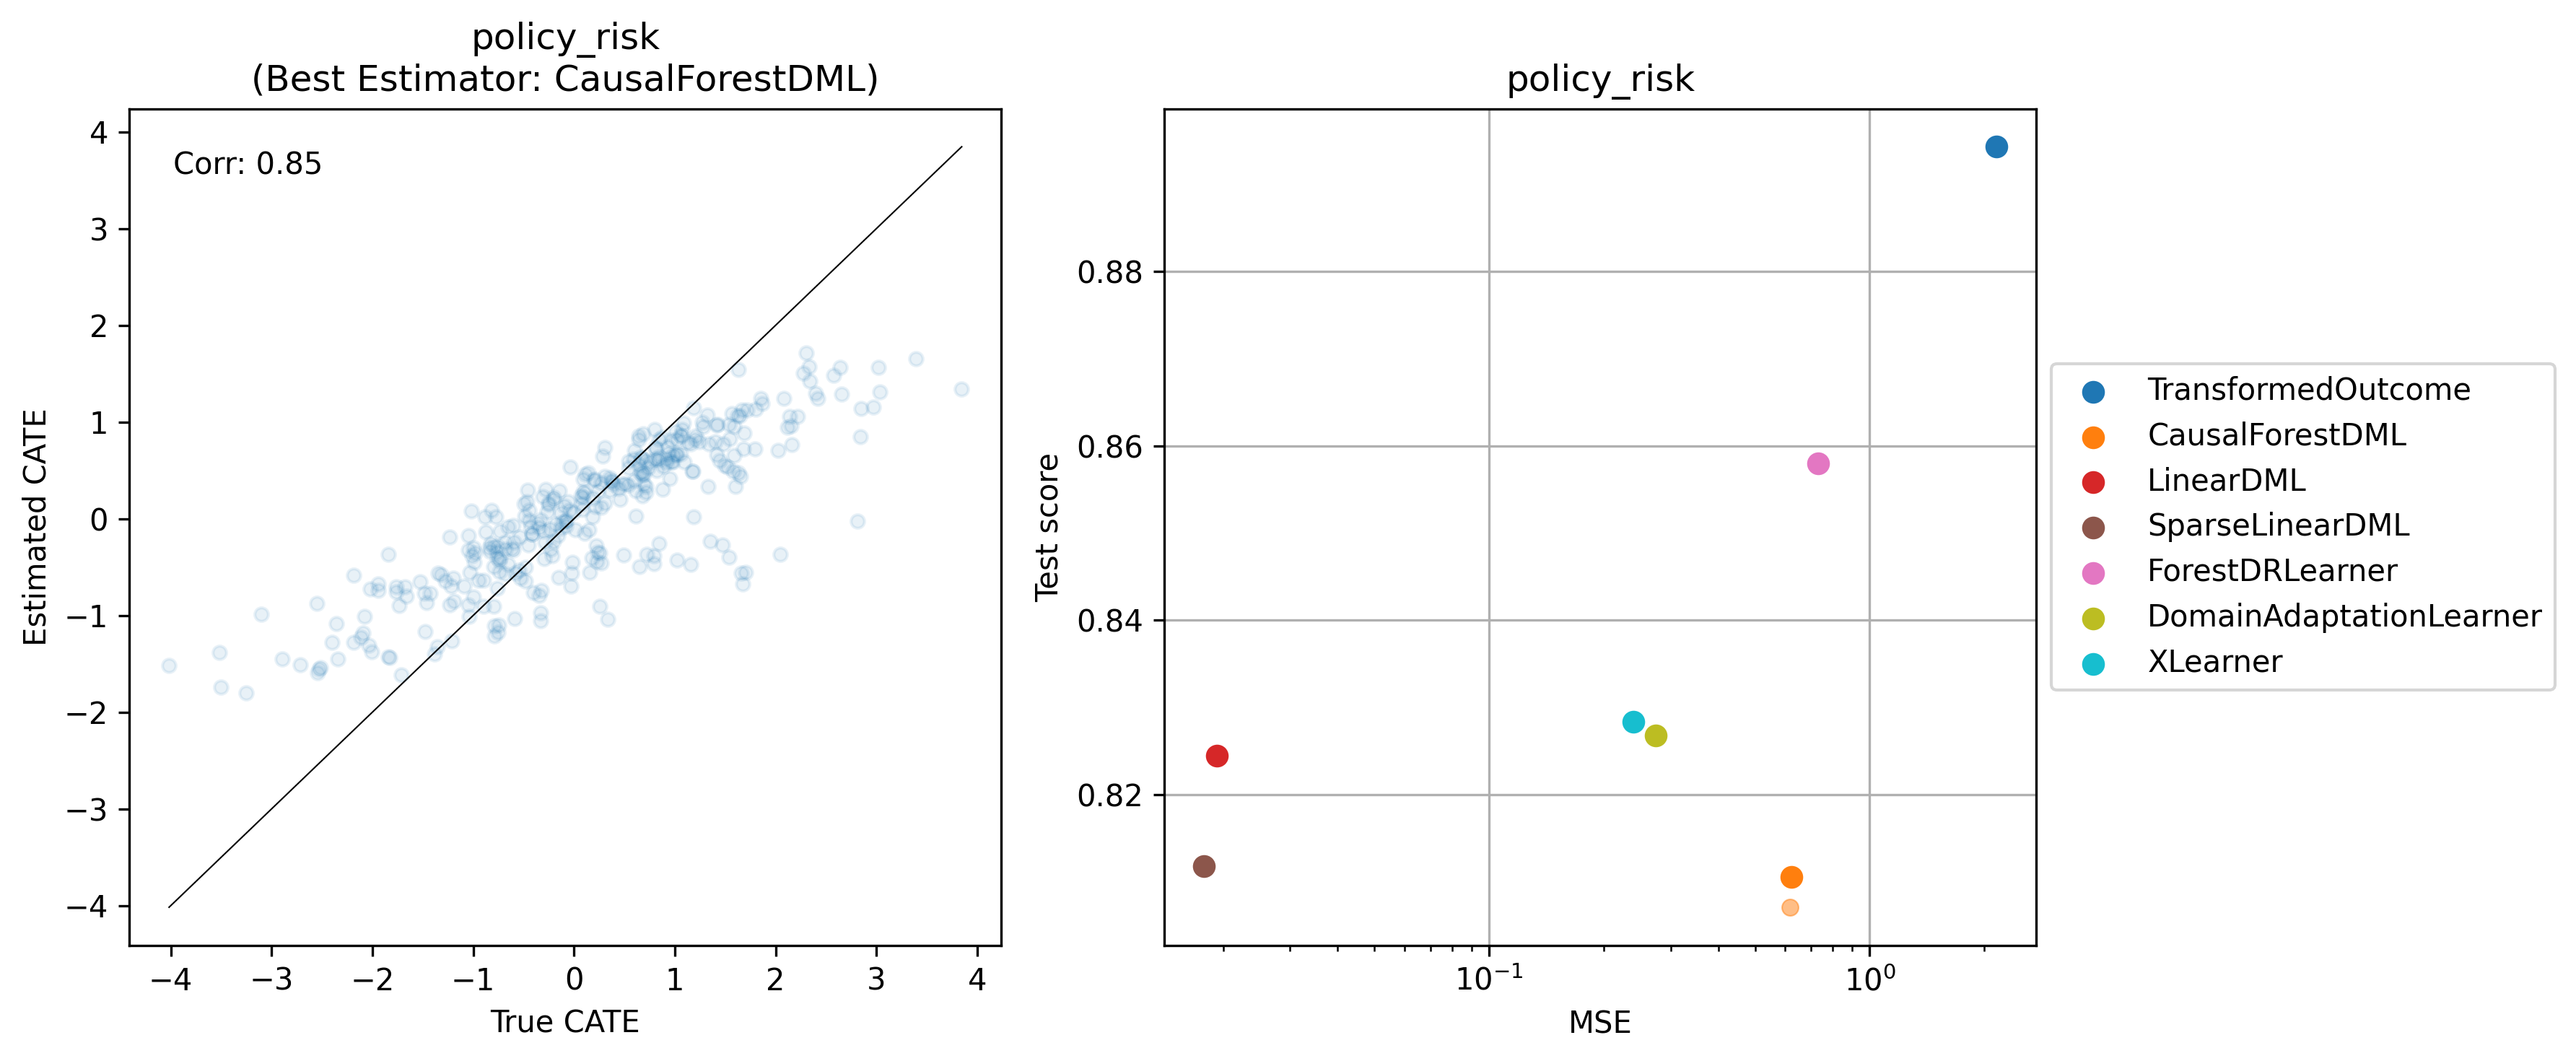

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import colorsys

# Function to scale lightness of a color
def scale_lightness(rgba, scale_l):
    r, g, b, a = rgba
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return (*colorsys.hls_to_rgb(h, min(1, l * scale_l), s), a)

# Set up the plot
plt.figure(figsize=(12, 5), dpi=300)

# Load data
metric = 'policy_risk'
filename = f"{out_dir}{filename_out}_{metric}_run_1.pkl"
with open(filename, "rb") as f:
    results = pickle.load(f)

# Subplot 1: Estimated CATE vs True CATE
ax1 = plt.subplot(121)

best_estimator = results["best_estimator"]
CATE_gt = results["scores_per_estimator"][best_estimator][0]["test"]["CATE_groundtruth"]
CATE_est = results["scores_per_estimator"][best_estimator][0]["test"]["CATE_estimate"]

# Ensure CATE_gt and CATE_est are 1D arrays
CATE_gt = np.array(CATE_gt).flatten()
CATE_est = np.array(CATE_est).flatten()

ax1.scatter(CATE_gt, CATE_est, s=20, alpha=0.1)
ax1.plot([min(CATE_gt), max(CATE_gt)], [min(CATE_gt), max(CATE_gt)], "k-", linewidth=0.5)

ax1.set_xlabel("True CATE")
ax1.set_ylabel("Estimated CATE")
ax1.set_title(f"{metric}\n(Best Estimator: {best_estimator.split('.')[-1]})")

# Calculate and display correlation coefficient
corr = np.corrcoef(CATE_gt, CATE_est)[0, 1]
ax1.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax1.transAxes, 
         verticalalignment='top', fontsize=10)

# Subplot 2: MSE vs Score
ax2 = plt.subplot(122)

colors = plt.cm.tab10(np.linspace(0, 1, len(results["scores_per_estimator"])))
est_labels = []

for (est_name, scr), col in zip(results["scores_per_estimator"].items(), colors):
    if "Dummy" not in est_name:
        if len(scr):
            # Plot intermediate runs
            if len(scr) > 1:
                lightness = np.linspace(1, 2.8, len(scr))
                for i_run in range(1, len(scr)):
                    CATE_gt = np.array(scr[i_run]["test"]["CATE_groundtruth"]).flatten()
                    CATE_est = np.array(scr[i_run]["test"]["CATE_estimate"]).flatten()
                    mse = np.mean((CATE_gt - CATE_est)**2)
                    score = scr[i_run]["test"][metric]
                    ax2.scatter(mse, score, color=scale_lightness(col, lightness[i_run-1]), 
                                s=30, linewidths=0.5, alpha=0.5)
            
            # Plot best estimator
            CATE_gt = np.array(scr[0]["test"]["CATE_groundtruth"]).flatten()
            CATE_est = np.array(scr[0]["test"]["CATE_estimate"]).flatten()
            mse = np.mean((CATE_gt - CATE_est)**2)
            score = scr[0]["test"][metric]
            ax2.scatter(mse, score, color=col, s=50, linewidths=0.5, label=est_name.split(".")[-1])
            est_labels.append(est_name.split(".")[-1])

ax2.set_xlabel("MSE")
ax2.set_ylabel("Test score")
ax2.set_title(f"{metric}")
ax2.set_xscale("log")
ax2.grid(True)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f"{metric}_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()